# Linkedin Post Generator


In [145]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import TypedDict,Literal,Annotated
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import operator
from dotenv import load_dotenv
load_dotenv()

True

In [146]:
# three LLMs
# generator
llm_gen=ChatOpenAI(model='gpt-4o-mini')
# evaluator
llm_eval=ChatOpenAI(model='gpt-4o-mini')
# optimizer
llm_opt=ChatOpenAI(model='gpt-4o-mini')


In [ ]:
# state
class PostState(TypedDict):
    topic:str
    post:str
    evaluation: Literal['approved','needs_improvement']
    feedback:str
    iteration:int
    max_iteration:int
    post_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [148]:
class Evaluation_schema(BaseModel):
    evaluation:  Literal['approved','needs_improvement'] =Field(description="Evaluation of the lniked post either approved or need improvement")
    feedback: str = Field(description="Feedback of the linkedin post")

In [149]:
llm_structured_evaluator=llm_eval.with_structured_output(Evaluation_schema)

In [150]:
# code for gen_post

def gen_post(state:PostState)->PostState:


    prompt=ChatPromptTemplate.from_messages(
        [
        ("system",'you are a expert linkedin post generator in day to day language'),
        ("user","""Topic: {topic}\n generate a linkedin post on this topic with simple day to day English. Post should be informative and short to the point\n
         Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Think in meme logic, punchlines, or relatable takes.""")
    ])
    chain= prompt | llm_gen | StrOutputParser()
    post=chain.invoke({'topic':state['topic']})
    return {'post':post,
            'post_history':[post]}

In [151]:
# code for eval_post
def eval_post(state:PostState)->PostState:

    prompt=ChatPromptTemplate.from_messages([
        ("system","You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and linkedin post format."),
        ("user","""
Evaluate the following tweet:

Tweet: "{post}"

Use the criteria below to evaluate the linkedin post:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
    ])
    chain=prompt | llm_structured_evaluator
    evaluation=chain.invoke({'post':state['post']})
    return {'evaluation':evaluation.evaluation,'feedback':evaluation.feedback,
            'feedback_history':[evaluation.feedback]}
    

In [152]:
# code for optimize_post

def optimize_post(state:PostState)->PostState:
    prompt=ChatPromptTemplate.from_messages([
        ("system","You punch up linkedin  for virality and humor based on given feedback"),
        ("user","""
Improve the linkedin post  based on this feedback:
"{feedback}"

Topic: "{topic}"
Original post:
{post}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ])
    chain=prompt | llm_opt | StrOutputParser()
    opt=chain.invoke({
        'feedback': state['feedback'],
        'topic':state['topic'],
        'post':state['post']
     })
    iteration_n=state['iteration'] +1
    return {'post':opt,
            'iteration':iteration_n,
            'post_history':[opt]}

In [153]:
# code for check_eval
def check_eval(state:PostState):
    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [154]:
graph=StateGraph(PostState)

graph.add_node('gen_post',gen_post)
graph.add_node('eval_post',eval_post)
graph.add_node('optimize_post',optimize_post)

graph.add_edge(START,'gen_post')
graph.add_edge('gen_post','eval_post')
graph.add_conditional_edges('eval_post',check_eval,{'approved':END,'needs_improvement':'optimize_post'})
graph.add_edge('optimize_post','eval_post')

workflow=graph.compile()

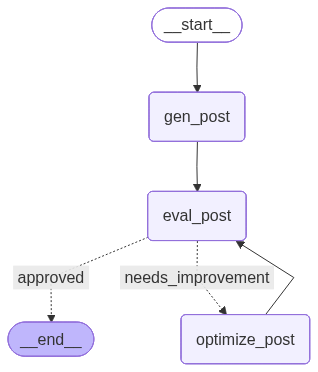

In [155]:
workflow

In [156]:
result=workflow.invoke({
    'topic':"Agentic Ai limiatations",
    'iteration':1,
    'max_iteration':4
})

In [157]:
result

{'topic': 'Agentic Ai limiatations',
 'post': "🚨 Agentic AI: Think of it as that friend who confidently claims they can cook gourmet, but still burns toast! 🤖🔥 Sure, it makes decisions, but without context and a sprinkle of empathy, it's just a glorified calculator! Let’s steer our tech dreams wisely! #AIlife #TechTruths",
 'evaluation': 'approved',
 'feedback': "This tweet showcases originality with a clever analogy comparing Agentic AI to an overconfident friend, which adds a relatable touch. The humor is light but effective, eliciting a chuckle rather than a full laugh, making it approachable. It's punchy enough, though it could be slightly tighter; still, it captures attention. Its potential for virality is decent, as many will likely relate to both the humor and the insight about AI's limitations. Finally, the format adheres to the Twitter guidelines, making it a well-formed tweet.",
 'iteration': 3,
 'max_iteration': 4,
 'post_history': ["🚨 Agentic AI is getting smarter, but it s

In [158]:
print(result['post'])

🚨 Agentic AI: Think of it as that friend who confidently claims they can cook gourmet, but still burns toast! 🤖🔥 Sure, it makes decisions, but without context and a sprinkle of empathy, it's just a glorified calculator! Let’s steer our tech dreams wisely! #AIlife #TechTruths
